# Machine Learning: Popularity Prediction

In [1]:
# ============================================================================
# MACHINE LEARNING PIPELINE: POPULARITY PREDICTION
# ============================================================================

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')



In [26]:
df_clean_path = r"D:\UNH Materials\Projects\Spotify Song Recommendations\data\df_clean.csv"


# Step 1: Create a copy of df_clean
ml_df = pd.read_csv(df_clean_path)
print(f"\n1. Created ml_df with shape: {ml_df.shape}")


1. Created ml_df with shape: (8582, 36)


In [3]:
ml_df.columns

Index(['track_uri', 'track_name', 'artist_uri(s)', 'artist_name(s)',
       'album_uri', 'album_name', 'album_artist_uri(s)',
       'album_artist_name(s)', 'album_release_date', 'album_image_url',
       'disc_number', 'track_number', 'track_duration_(ms)',
       'track_preview_url', 'explicit', 'popularity', 'artist_genres',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'label', 'release_year', 'release_month',
       'release_quarter', 'release_week', 'release_day_of_week',
       'track_duration_min'],
      dtype='object')

In [28]:
ml_df['explicit'] = ml_df['explicit'].map({True: 1, False: 0})
ml_df['mode'] = ml_df['mode'].map({1.0: 'Mjor', 0.0: 'Minor'})

In [30]:
print("="*80)
print("MACHINE LEARNING: POPULARITY PREDICTION")
print("="*80)


# Step 2: Select features for training
# Numerical features (audio features that might predict popularity)
numerical_features = ['danceability', 'energy', 'key', 'loudness',  
                     'instrumentalness', 'tempo', 'duration_min', 'explicit',
                     'valence', 'acousticness', 'liveness', 'speechiness']

# Categorical features
categorical_features = ['mode']

# Check if features exist and remove any that don't
available_numerical = [f for f in numerical_features if f in ml_df.columns]
available_categorical = [f for f in categorical_features if f in ml_df.columns]

print(f"\n2. Selected Features:")
print(f"   Numerical features ({len(available_numerical)}): {available_numerical}")
print(f"   Categorical features ({len(available_categorical)}): {available_categorical}")

# Step 3: Prepare target variable
target = 'popularity'
X = ml_df[available_numerical + available_categorical]
y = ml_df[target]

print(f"\n3. Target variable: {target}")
print(f"   Target range: {y.min():.1f} to {y.max():.1f}")
print(f"   Target mean: {y.mean():.2f}")

# # Step 4: Handle missing values
# print(f"\n4. Handling missing values...")
# print(f"   Missing values in features: {X.isnull().sum().sum()}")
# X = X.fillna(X.mode().iloc[0] if len(X.mode()) > 0 else 0)  # Fill with mode or 0

## Step 5: Encode categorical features (using One-Hot Encoding)
print(f"\n5. Encoding categorical features with One-Hot Encoding...")
X_encoded = X.copy()

# Store original column names before encoding
original_columns = X_encoded.columns.tolist()

# Separate numerical and categorical columns
X_numerical = X_encoded[available_numerical].copy()
X_categorical = X_encoded[available_categorical].copy()

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)
X_categorical_encoded = ohe.fit_transform(X_categorical)

# Get feature names for encoded categorical columns
categorical_feature_names = ohe.get_feature_names_out(available_categorical)

# Combine numerical and encoded categorical features
X_encoded = pd.DataFrame(
    data=np.hstack([X_numerical.values, X_categorical_encoded]),
    columns=list(available_numerical) + list(categorical_feature_names),
    index=X_encoded.index
)

# Print encoding information for each categorical column
for col in available_categorical:
    print(f"   Encoded '{col}': {X[col].nunique()} unique values")

# Step 6: Train-Test Split
print(f"\n6. Performing train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=None
)
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Test set: {X_test.shape[0]:,} samples")

# Step 7: Scale numerical features
print(f"\n7. Scaling numerical features...")
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[available_numerical] = scaler.fit_transform(X_train[available_numerical])
X_test_scaled[available_numerical] = scaler.transform(X_test[available_numerical])

print(f"   Scaling completed for {len(available_numerical)} numerical features")

# Prepare feature names for later use
# feature_names = available_numerical + available_categorical
feature_names = X_encoded.columns.tolist()

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)

MACHINE LEARNING: POPULARITY PREDICTION

2. Selected Features:
   Numerical features (11): ['danceability', 'energy', 'key', 'loudness', 'instrumentalness', 'tempo', 'explicit', 'valence', 'acousticness', 'liveness', 'speechiness']
   Categorical features (1): ['mode']

3. Target variable: popularity
   Target range: 0.0 to 98.0
   Target mean: 37.80

5. Encoding categorical features with One-Hot Encoding...
   Encoded 'mode': 2 unique values

6. Performing train-test split...
   Training set: 6,865 samples
   Test set: 1,717 samples

7. Scaling numerical features...
   Scaling completed for 11 numerical features

DATA PREPARATION COMPLETE


In [37]:
# Step 8: Train Multiple Models
print("="*80)
print("TRAINING MODELS")
print("="*80)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=5, 
                                            min_samples_split=2),
    # 'SVM': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42, min_samples_split=2, 
                                                   max_depth=5)
}

# Dictionary to store results
results = {}

print("\nTraining models...")
for name, model in models.items():
    print(f"\n  Training {name}...", end=" ")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }
    
    print(f"✓ (Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.2f})")

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)

TRAINING MODELS

Training models...

  Training Linear Regression... ✓ (Test R²: 0.0039, Test RMSE: 29.49)

  Training Ridge Regression... ✓ (Test R²: 0.0039, Test RMSE: 29.49)

  Training Random Forest... ✓ (Test R²: 0.0053, Test RMSE: 29.47)

  Training Gradient Boosting... ✓ (Test R²: -0.0430, Test RMSE: 30.17)

ALL MODELS TRAINED SUCCESSFULLY


In [38]:
# Step 9: Display Results Table
print("="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Train MAE': [results[m]['train_mae'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()]
})

# Sort by Test R² (descending)
results_df = results_df.sort_values('Test R²', ascending=False)

print("\nResults Summary (sorted by Test R²):")
print("-"*80)
print(results_df.to_string(index=False))
print("-"*80)

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test R²']
best_test_rmse = results_df.iloc[0]['Test RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {best_test_r2:.4f}")
print(f"   Test RMSE: {best_test_rmse:.2f}")

MODEL EVALUATION RESULTS

Results Summary (sorted by Test R²):
--------------------------------------------------------------------------------
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²
    Random Forest   28.830942  29.465570  25.699719 26.067271  0.060120  0.005295
 Ridge Regression   29.541737  29.486426  26.355981 26.162548  0.013205  0.003886
Linear Regression   29.541737  29.486447  26.355963 26.162545  0.013205  0.003885
Gradient Boosting   22.635955  30.172359  19.504702 26.236451  0.420635 -0.042997
--------------------------------------------------------------------------------

🏆 Best Model: Random Forest
   Test R²: 0.0053
   Test RMSE: 29.47


In [39]:
# Step 10: Feature Importance (for tree-based models)
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance_dict = {}

# Get feature importance from tree-based models
for name, result in results.items():
    model = result['model']
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_dict[name] = dict(zip(feature_names, importances))
        print(f"\n{name} - Top 5 Features:")
        sorted_features = sorted(feature_importance_dict[name].items(), 
                                key=lambda x: x[1], reverse=True)[:5]
        for feat, imp in sorted_features:
            print(f"  {feat:20s}: {imp:.4f}")

# For Linear/Ridge models, use absolute coefficients as importance
for name, result in results.items():
    model = result['model']
    if hasattr(model, 'coef_'):
        coefs = np.abs(model.coef_)
        feature_importance_dict[name] = dict(zip(feature_names, coefs))
        print(f"\n{name} - Top 5 Features (by absolute coefficient):")
        sorted_features = sorted(feature_importance_dict[name].items(), 
                                key=lambda x: x[1], reverse=True)[:5]
        for feat, imp in sorted_features:
            print(f"  {feat:20s}: {imp:.4f}")


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 5 Features:
  acousticness        : 0.1606
  danceability        : 0.1575
  valence             : 0.1155
  liveness            : 0.1105
  loudness            : 0.0980

Gradient Boosting - Top 5 Features:
  tempo               : 0.1358
  acousticness        : 0.1249
  valence             : 0.1135
  loudness            : 0.1134
  liveness            : 0.1063

Linear Regression - Top 5 Features (by absolute coefficient):
  danceability        : 1.9252
  explicit            : 1.3470
  loudness            : 1.2485
  acousticness        : 1.0586
  valence             : 0.9927

Ridge Regression - Top 5 Features (by absolute coefficient):
  danceability        : 1.9248
  explicit            : 1.3469
  loudness            : 1.2482
  acousticness        : 1.0584
  valence             : 0.9924


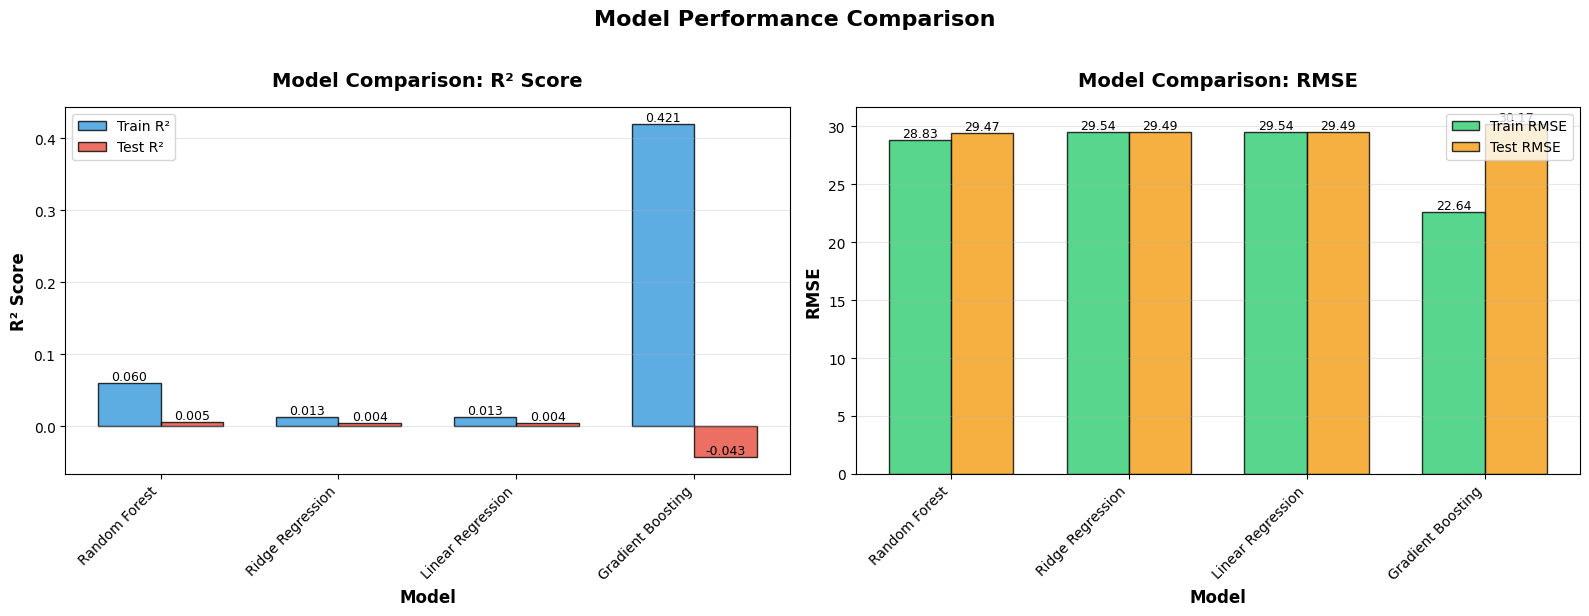

In [40]:
# Step 11: Visualizations

# 11.1: Model Comparison (R² and RMSE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² Comparison
ax1 = axes[0]
models_list = results_df['Model'].values
train_r2_values = results_df['Train R²'].values
test_r2_values = results_df['Test R²'].values

x_pos = np.arange(len(models_list))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, train_r2_values, width, label='Train R²', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, test_r2_values, width, label='Test R²', 
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: R² Score', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# RMSE Comparison
ax2 = axes[1]
train_rmse_values = results_df['Train RMSE'].values
test_rmse_values = results_df['Test RMSE'].values

bars3 = ax2.bar(x_pos - width/2, train_rmse_values, width, label='Train RMSE', 
                color='#2ecc71', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x_pos + width/2, test_rmse_values, width, label='Test RMSE', 
                color='#f39c12', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

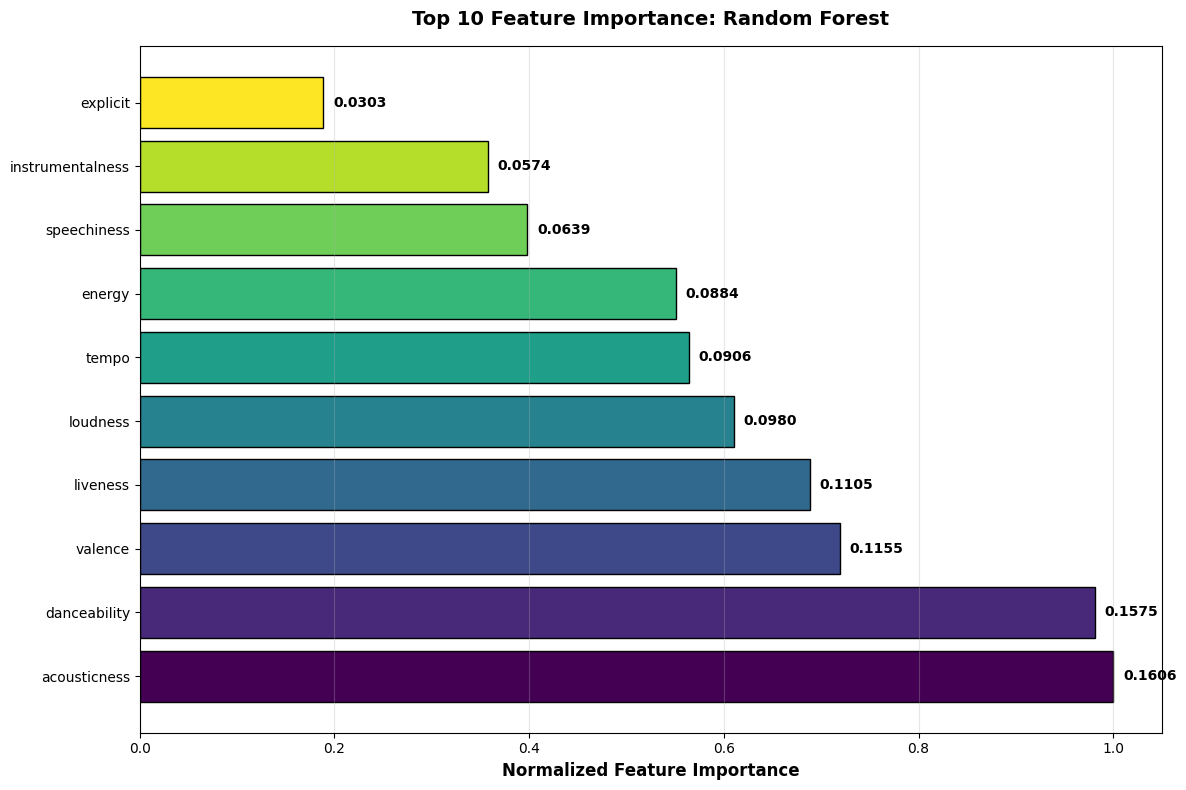

In [41]:
# 11.2: Top 10 Feature Importance (for best tree-based model)
# Use Random Forest or Gradient Boosting for feature importance
tree_models = ['Random Forest', 'Gradient Boosting']
available_tree_model = None
for model_name in tree_models:
    if model_name in feature_importance_dict:
        available_tree_model = model_name
        break

if available_tree_model:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top 10 features
    importances = feature_importance_dict[available_tree_model]
    sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
    features = [f[0] for f in sorted_features]
    importance_values = [f[1] for f in sorted_features]
    
    # Normalize importance values for better visualization
    max_imp = max(importance_values)
    normalized_imp = [v / max_imp for v in importance_values]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
    bars = ax.barh(range(len(features)), normalized_imp, color=colors, edgecolor='black')
    
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    ax.set_xlabel('Normalized Feature Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 Feature Importance: {available_tree_model}', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val, orig_val) in enumerate(zip(bars, normalized_imp, importance_values)):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
               f'{orig_val:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No tree-based model available for feature importance visualization.")

IndexError: index 3 is out of bounds for axis 0 with size 3

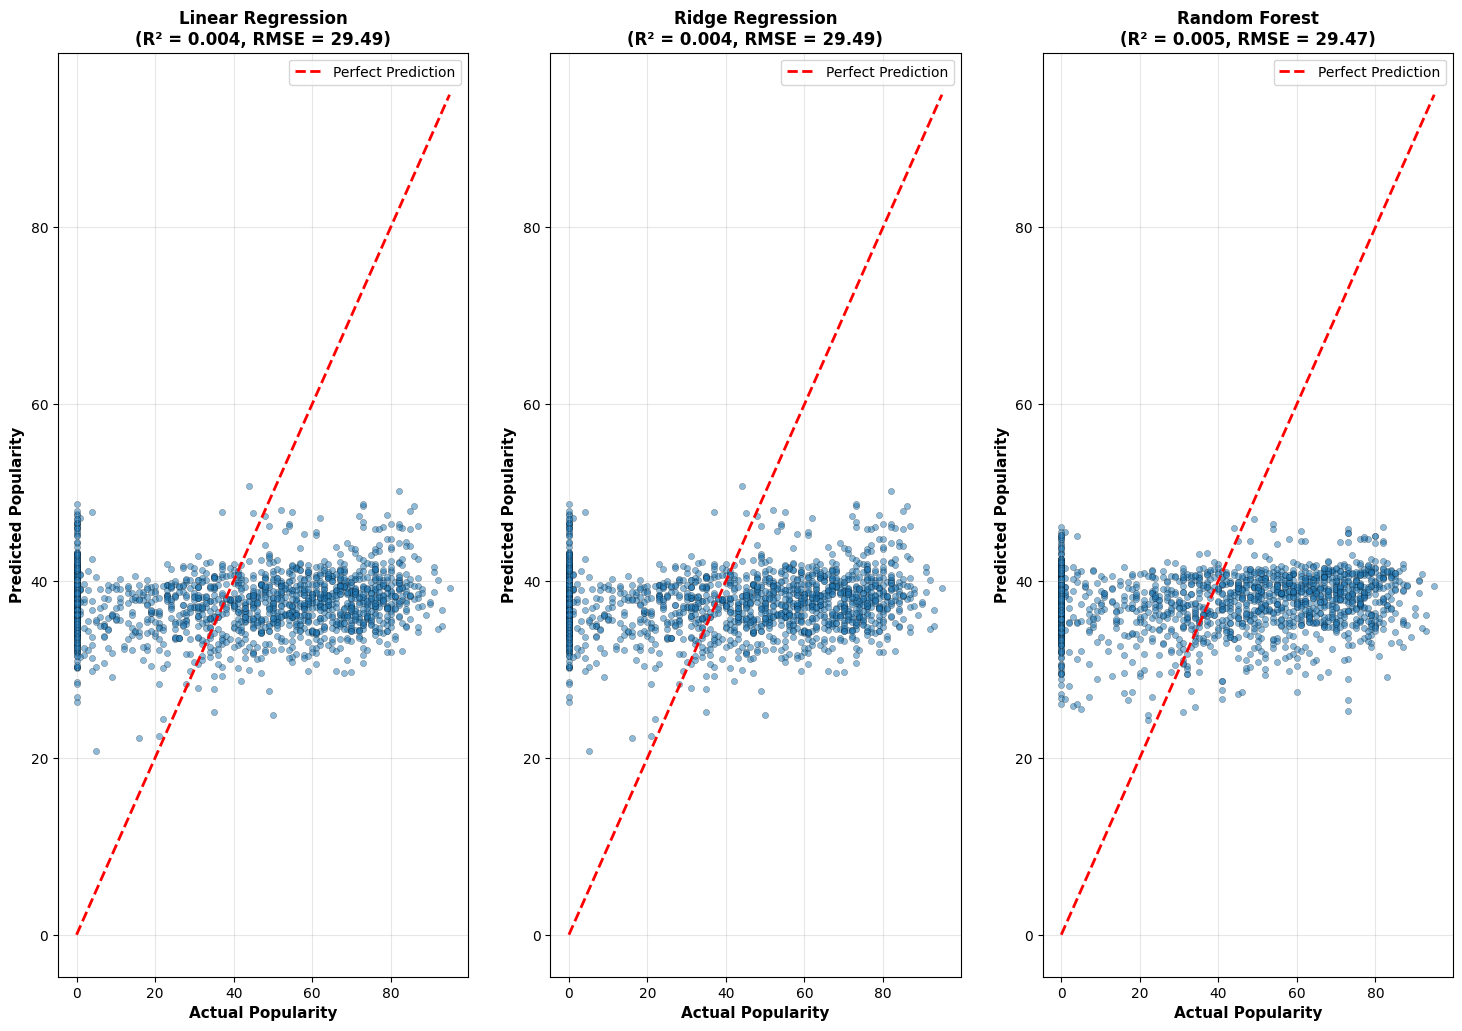

In [42]:
# 11.3: Actual vs Predicted Values (for all models)
fig, axes = plt.subplots(1, 3, figsize=(18, 12))
axes = axes.ravel()

# Remove last subplot if we have 5 models
if len(models) == 5:
    fig.delaxes(axes[5])

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    # Use test set predictions
    y_actual = y_test.values
    y_pred = result['y_test_pred']
    
    # Scatter plot
    ax.scatter(y_actual, y_pred, alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
    
    # Perfect prediction line (y=x)
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Labels and title
    ax.set_xlabel('Actual Popularity', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Popularity', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\n(R² = {result["test_r2"]:.3f}, RMSE = {result["test_rmse"]:.2f})', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted Popularity (Test Set)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [43]:
# Step 12: Summary Statistics
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\nDataset Information:")
print(f"  Total samples: {len(ml_df):,}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features used: {len(feature_names)}")

print(f"\nTarget Variable Statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.1f}")
print(f"  Max: {y.max():.1f}")

print(f"\nBest Model Performance ({best_model_name}):")
print(f"  Test R²: {best_test_r2:.4f}")
print(f"  Test RMSE: {best_test_rmse:.2f}")
print(f"  Test MAE: {results[best_model_name]['test_mae']:.2f}")

print("\n" + "="*80)
print("MACHINE LEARNING PIPELINE COMPLETE")
print("="*80)


FINAL SUMMARY

Dataset Information:
  Total samples: 8,582
  Training samples: 6,865
  Test samples: 1,717
  Features used: 13

Target Variable Statistics:
  Mean: 37.80
  Std: 29.70
  Min: 0.0
  Max: 98.0

Best Model Performance (Random Forest):
  Test R²: 0.0053
  Test RMSE: 29.47
  Test MAE: 26.07

MACHINE LEARNING PIPELINE COMPLETE
